In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install gpytorch

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 18.1 MB/s eta 0:00:00


In [2]:
from itertools import product
import math
import time
import glob
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as st
import torch
import gpytorch

In [41]:
N_CLUSTERS = None

def estimate_density(x, k=5):
    """Estimate the density of a dataset using the k-nearest neighbors method.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        The dataset for which to estimate the density.
    k : int, optional (default=5)
        The number of nearest neighbors to use for density estimation.
    
    Returns
    -------
    densities : array, shape (n_samples,)
        The estimated densities for each sample in the dataset.
    """
    dens = np.zeros(len(x))

    # The volume of a unit d-dimensional ball is given by the formula
    d = len(x[0])
    volume = math.pi ** (d / 2) / math.gamma(d / 2 + 1)

    for i in range(len(x)):
      r  = np.sort(
          np.sqrt(
              np.sum([(x[:,j] - x[i][j])**2 for j in range(len(x[0]))], axis=0)
              )
          )[k]
      
      dens[i] = k/(volume * (r**d))
      #dens[i] = k/(r**2)

    return dens 



class Clusters:
    def __init__(self, features='all', N=5000, path="./drive/MyDrive/star_clusters_gen/data/", generate=False, mean=None, cov=None):
      self.N = N
      if features == 'all':
        self.mask = range(0, 7)
      elif features == 'pos':
        self.mask = range(1, 4)
      elif features == 'vel':
        self.mask = range(4, 7)
      else:
        print(f'[WARNING] {features} features not recognized! Full features are used.')
        self.mask = range(0, 7)
      self.dims = len(self.mask)
      self.iter_train = 0
      self.iter_val = 0
      self.n_train = 7
      self.n_val = 3
      if generate:
        self._mean = [0]*self.dims if mean==None else mean
        self._cov = self.generate_random_spd_matrix() if cov==None else cov
        self.data = np.random.multivariate_normal(self._mean, self._cov, self.N)
      else:
        self.path = path
        files = glob.glob(path + 'sink*')
        global N_CLUSTERS
        N_CLUSTERS = len(files)
        self.data_train = np.empty((self.n_train,), dtype=np.ndarray)
        self.data_val = np.empty((self.n_val,), dtype=np.ndarray)
        self.names_train = []
        self.names_val = []
        for i in range(N_CLUSTERS):
          if i < self.n_train:
            self.data_train[i] = np.loadtxt(files[i], skiprows=1)[:,mask]
            self.names_train.append(files[i][-9:])
          else:
            self.data_val[i - self.n_train] = np.loadtxt(files[i], skiprows=1)[:,mask]
            self.names_val.append(files[i][-9:])

    def next_train(self, return_name=False):
        self.iter_train += 1
        if return_name:
          return self.data_train[(self.iter_train - 1)%self.n_train], self.names_train[(self.iter_train - 1)%self.n_train]
        else:
          return self.data_train[(self.iter_train - 1)%self.n_train]

    def next_val(self, idx, return_name=False):
        if return_name:
            return self.data_val[idx], self.names_val[idx]
        else:
            return self.data_val[idx]

    def count_stars_train(self):
        return np.sum([clusters.data_train[idx].shape[0] for idx in range(self.n_train)])

    def count_stars_val(self, idx):
        return clusters.data_val[idx].shape[0]    

    def generate_random_spd_matrix(self):
      # generate a random symmetric matrix
      A = np.random.rand(self.dims, self.dims)
      A = (A + A.T) / 2
      # ensure that the matrix is semi-positive definite by adding a multiple of the identity matrix
      I = np.eye(self.dims)
      A += 5 * I
      return A

    def subsample(self, n=300, plot=True):
       # select a random subsample
       idx = np.random.choice(np.arange(len(self.data)), n, False)
       x = self.data[idx]
       if plot and x.shape[1] == 2:
         plt.scatter(self.data[:,0], self.data[:,1], s=5)
         plt.scatter(x[:,0], x[:,1], c=estimate_density(x), edgecolor="k",s=60,cmap="plasma")
         plt.colorbar()
         plt.show()
       return x

    def get_bounds(self, X):
        # Getter for the bounds of the density map in each dimension
        bounds = []
        for d in range(self.dims):
            bounds.append((min(X[:, d]), max(X[:, d])))
        return bounds
    
    def get_ave_bounds(self):
      add = False
      for j in range(7):
        c = self.next_train()
        if add:
          ave_bounds += np.array(self.get_bounds(c))
        else:
          ave_bounds = np.array(self.get_bounds(c))
          add = True
      return ave_bounds/7


class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.LinearMean(train_x[0].size()[0])
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #print(covar_x.size())
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



class GP:
    def __init__(self, x, dims, k=5):
      self.dims = dims
      self.x = x
      self.train_x = torch.from_numpy(X)
      self.train_y = torch.from_numpy(estimate_density(X), k=k)
      self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
      self.model = ExactGPModel(train_x, train_y, likelihood)
      self.reshape_arr = None
      self.n_grid = None
      self.grid = None
      self.density_pred, self.cov_matrix, self.std = None, None, None
      self.x, self.grid = None, None

    def train(self, epochs=50):
      # find optimal model hyperparameters
      self.model.train()
      self.likelihood.train()

      # Use the adam optimizer, includes GaussianLikelihood parameters
      optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01) 

      # "Loss" for GPs - the marginal log likelihood
      mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)

      for i in range(epochs):
          # Zero gradients from previous iteration
          optimizer.zero_grad()
          # Output from model
          output = self.model(self.train_x)
          # Calc loss and backprop gradients
          loss = -mll(output, self.train_y)
          loss.backward()
          print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
              i + 1, epochs, loss.item(),
              self.model.covar_module.base_kernel.lengthscale.item(),
              self.model.likelihood.noise.item()
          ))
          optimizer.step()
   

    def predict(self, num):
      self.n_grid = num
      self.reshape_arr = tuple([num]*self.dims)
      # Input space
      grid_elements = [np.linspace(self.x[:,j].min(), self.x[:,j].max(), num=num) for j in range(len(self.x[0]))]  
      self.grid = torch.from_numpy(np.array(list(product(*grid_elements))))

      f_preds = self.model(self.grid)
      y_preds = self.likelihood(self.f_preds)

      f_mean = f_preds.mean
      f_var = f_preds.variance
      self.cov_matrix = f_preds.covariance_matrix
      f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

      self.std = np.diag(self.cov_matrix)
      return self.density_pred, self.std

    def generate_posteriors(self, posterior_num, plot=True):
      self.posteriors = st.multivariate_normal.rvs(mean=self.density_pred,
                                              cov=self.cov_matrix,
                                              size=posterior_num)
      self.posteriors[self.posteriors < 0] = 0
      
      if posterior_num == 1:
        self.posteriors = [self.posteriors]

      if plot:
        Xp = []
        for i in range(self.grid.shape[1]):
          Xp.append(self.grid[:,i].reshape(self.reshape_arr))
        fig = plt.figure(figsize=(posterior_num * 6, 4))
        ax = [None] * posterior_num
        im = [None] * posterior_num
        for i, posterior in enumerate(self.posteriors):
          Z = np.reshape(posterior, self.reshape_arr)
          if self.dims == 2:
            ax[i] = fig.add_subplot(100 + posterior_num * 10 + i + 1)
            im[i] = ax[i].pcolormesh(Xp[0], Xp[1], Z, cmap="plasma")
          elif self.dims == 3:
            ax[i] = fig.add_subplot(100 + posterior_num * 10 + i + 1, projection='3d')
            im[i] = ax[i].scatter(Xp[0], Xp[1], Xp[2], marker='s', s=200, c=Z, alpha=0.15)
          fig.colorbar(im[i], ax=ax[i])
          ax[i].set_title(f"Generated density map #{i+1}")
        plt.show()
      return [DensityMap(posterior, np.array(self.grid)) for posterior in self.posteriors]

    def plot(self):
        Z_mean = np.reshape(self.density_pred, self.reshape_arr)
        Z_std = np.reshape(self.std, self.reshape_arr)
        Xp = []
        for i in range(self.grid.shape[1]):
          Xp.append(self.grid[:,i].reshape(self.reshape_arr))
        fig = plt.figure(figsize=(16,6))
        if self.dims == 2:
          ax_1 = fig.add_subplot(121)
          ax_2 = fig.add_subplot(122)
          im_1 = ax_1.pcolormesh(Xp[0], Xp[1], Z_mean, cmap="plasma")
          plt.colorbar(im_1, ax=ax_1)
          ax_1.scatter(self.x[:,0], self.x[:,1],s=self.n_grid)
          ax_1.set_title("Mean density heatmap")
          im_2 = ax_2.pcolormesh(Xp[0], Xp[1], Z_std, cmap="plasma")
          fig.colorbar(im_2, ax=ax_2)
          ax_2.scatter(self.x[:,0], self.x[:,1],s=self.n_grid)
          ax_2.set_title("Std dev heatmap")
          plt.show()
        if self.dims == 3:
          # creating 3d figures
          ax_1 = fig.add_subplot(121, projection='3d')
          ax_2 = fig.add_subplot(122, projection='3d')
          # configuring colorbar
          # color_map_1 = cm.ScalarMappable(cmap=cm.plasma)
          # color_map_1.set_array(Z_mean)
          # color_map_2 = cm.ScalarMappable(cmap=cm.plasma)
          # color_map_2.set_array(Z_std)  
          # creating the heatmap
          ax_1.scatter(self.x[:,0], self.x[:,1], self.x[:,2], marker='s', s=4)
          im_1 = ax_1.scatter(Xp[0], Xp[1], Xp[2], marker='s', s=200, c=Z_mean, alpha=0.15)
          fig.colorbar(im_1, ax=ax_1)
          ax_2.scatter(self.x[:,0], self.x[:,1], self.x[:,2], marker='s', s=4)
          im_2 = ax_2.scatter(Xp[0], Xp[1], Xp[2], marker='s', s=200, c=Z_std, alpha=0.15)
          fig.colorbar(im_2, ax=ax_2)  
          # adding title and labels
          ax_1.set_title("3D Mean Density Heatmap")
          ax_2.set_title("3D Std Dev Heatmap")
            
          # displaying plot
          plt.show()


## Classes for samplers

In [44]:
class Sampler:
    def __init__(self, model, likelihood, clusters, num_samples, random_seed, verbose=True):
        """
        Initialize the sampler.

        Parameters
        ----------
        model: ExactGP model
            The model we trained for generating new realizations.
        likelihood: Likelihood function
            The likelihood function we use to predict the density
        cluster: Cluster object
            Object containing information about the training cluster - todo: multiple clusters
        num_samples: int
            The number of samples to generate.
        random_seed: int
            The random seed used to initialize the random number generator.
        """
        model.eval()
        self.model = model
        likelihood.eval()
        self.likelihood = likelihood
        self.clusters = clusters
        self.num_samples = num_samples
        self.random_seed = random_seed
        self.num_dimensions = len(clusters.mask)
        self.verbose = verbose

    def _interpolate(self, point):
        """
        TODO? - i am not sure if it is needed - it depends on the grid step and
        the number of stars in the sample

        Use linear interpolation to estimate the density at a point.

        Parameters
        ----------
        point: array
            An array of shape (D,) containing the point at which to estimate the density.

        Returns
        -------
        density: float
            The estimated density at the point.
        """
        return

    def truncated_normal(self, mean, cov, size):
      """
      Generate samples from a truncated normal distribution.

      Parameters
      ----------
      mean: array
          An array of shape (D,) specifying the mean of the normal distribution.
      cov: float
          The covariance of the normal distribution.
      size: int
          The number of samples to generate.

      Returns
      -------
      samples: array
          An array of shape (size, D) containing the generated samples.
      """
      # initialize the samples array
      samples = np.zeros((size, len(mean)))

      #  specifying the bounds of the truncated normal distribution in each dimension.
      bounds = self.clusters.get_ave_bounds()

      # Generate samples from the truncated normal distribution in each dimension
      for d in range(len(mean)):
          a, b = bounds[d]
          mu = mean[d]
          sigma = cov[d] #if d else cov * 10
          samples[:, d] = st.truncnorm((a - mu) / sigma, (b - mu) / sigma, mu, sigma).rvs(size=size)

      return samples

    def predict_density(self, grid_point):
        grid_point = torch.from_numpy(grid_point).float().unsqueeze(0).cuda()
        f_preds = self.model(grid_point)
        y_preds = self.likelihood(self.model(grid_point))
        with torch.no_grad():
            return y_preds.mean[0].cpu().numpy()
        #return y_preds.sample()[0].cpu().numpy()


class MCMCSampler(Sampler):
    def sample(self, step_size=0.8, goback=False, random_walk=False, ref=None):
        """
        Generate samples from the density map using MCMC sampling*.
        * this is a modified version in which the previous value is not kept
        when a sample is rejected - the sampler iterates again until the counter
        reaches the number of desired samples.

        Returns
        -------
        samples: array
            An array of shape (num_samples, num_dimensions) containing the generated samples.
        """
        # initialize the samples array and set the initial sample, declare const
        samples = np.zeros((self.num_samples, self.num_dimensions))
        samples[0] = np.zeros(self.num_dimensions)
        attempts = 0
        if not random_walk:
          step_size = [step_size] * clusters.dims
        density = self.predict_density(samples[0])
        prev_density = density.copy() 
        np.random.seed(self.random_seed)
        t0 = time.time()
        # run the MCMC sampler
        count = 1 if ref is None else 0
        while count < self.num_samples:
            attempts += 1
            if goback:
              return_point_idx = np.random.randint(0, count)
            if random_walk:
                if ref is None:
                  step_size_p = np.random.uniform(0.000001, 0.05)
                  step_size_v = np.random.uniform(0.0001, 0.01, 3)
                  step_size_m = np.random.uniform(10, 50)
                else:
                  step_size_p = np.random.uniform(0.000001, 0.01)
                  step_size_v = np.random.uniform(0.00001, 0.01, 3)
                  step_size_m = np.random.uniform(0.0001, 0.01)

                step_size = [step_size_p]*3 + list(step_size_v) + [step_size_m]
            
            if attempts > 20:
              for idx, s in enumerate(step_size):
                step_size[idx] = s * 10            

            if ref is None:
              sampling_center = samples[return_point_idx] if goback else samples[count-1]
            else:
              sampling_center = ref[count]
            
            # sample a new point from a truncated normal distribution centered at the current point
            new_point = self.truncated_normal(mean=sampling_center, cov=step_size, size=1)

            # the density at the new point
            density = self.predict_density(new_point)
 
            # the acceptance probability
            acceptance_prob = np.min([1.0, density / prev_density])

            # apply Metropolis algorithm to decide if accept the new point
            
            if self.verbose and count % 100 == 0:
                t1 = time.time()
                print('%d/%d generated samples [time: %.3f minutes]' % (count, self.num_samples, (t1-t0)/60))

            if np.random.rand() < acceptance_prob:
                samples[count] = new_point
                count +=1
                attempts = 0
                if ref is None:
                  prev_density = density.copy() 
                else:
                  prev_density = self.predict_density(ref[count])
            else:
                pass
                # samples[count] = samples[count - 1].copy()
                # p = np.random.choice(3, 1)[0]
                # samples[count][p + 1] = -samples[count][p + 1]
            
        return samples


class RejectionSampler(Sampler):
  def sample(self):
        """
        Generate samples from the density map using rejection sampling.

        Returns
        -------
        samples: array
            An array of shape (num_samples, num_dimensions) containing the generated samples.
        """

        # initialize, declare the sampler constants 

        max_density = 1
        bounds = self.clusters.get_ave_bounds()

        samples = np.zeros((self.num_samples, self.num_dimensions))
        samples[0] = np.zeros(self.num_dimensions)

        density = self.predict_density(samples[0])
        prev_density = density.copy() 
        np.random.seed(self.random_seed)

        t0 = time.time()
        # run the rejection sampler
        count = 1
        while count < self.num_samples:
            
            # sample a point uniformly at random from the sample space
            sample = []
            for d in range(self.num_dimensions):
                lower, upper = bounds[d]
                sample.append(np.random.uniform(lower, upper))

            # accept the sample with probability proportional to its density
            density = self.predict_density(np.array(sample))
            if density > max_density:
              max_density = density
            if np.random.rand() < density / max_density:
                samples[count] = sample
                count += 1
                if self.verbose and count % 100 == 0:
                  t1 = time.time()
                  print('%d/%d generated samples [time: %.3f minutes]' % (count, self.num_samples, (t1-t0)/60))
      

        return samples

## Model Training

In [42]:
# data
clusters = Clusters(features='pos')

In [28]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
X, cluster_name_tr = clusters.next_train(return_name=True)
train_x = torch.from_numpy(X).float().cuda()
train_y = torch.from_numpy(estimate_density(X)).float().cuda()
model = ExactGPModel(train_x, train_y, likelihood).cuda()

In [29]:
cluster_name_tr

'm8.e4.dat'

Iter 1/1000 - Loss: 7773316.000  -  lengthscale: 0.010 - noise: 23.553
Iter 2/1000 - Loss: 7776911.000  -  lengthscale: 0.011 - noise: 23.653
Iter 3/1000 - Loss: 7726782.000  -  lengthscale: 0.010 - noise: 23.753
Iter 4/1000 - Loss: 7702319.000  -  lengthscale: 0.010 - noise: 23.853
Iter 5/1000 - Loss: 7700463.500  -  lengthscale: 0.009 - noise: 23.952
Iter 6/1000 - Loss: 7644314.000  -  lengthscale: 0.010 - noise: 24.052
Iter 7/1000 - Loss: 7599296.500  -  lengthscale: 0.010 - noise: 24.150
Iter 8/1000 - Loss: 7580021.000  -  lengthscale: 0.010 - noise: 24.249
Iter 9/1000 - Loss: 7557886.500  -  lengthscale: 0.011 - noise: 24.348
Iter 10/1000 - Loss: 7531645.500  -  lengthscale: 0.011 - noise: 24.447
Iter 11/1000 - Loss: 7521937.500  -  lengthscale: 0.011 - noise: 24.547
Iter 12/1000 - Loss: 7483731.500  -  lengthscale: 0.011 - noise: 24.646
Iter 13/1000 - Loss: 7454924.500  -  lengthscale: 0.010 - noise: 24.746
Iter 14/1000 - Loss: 7413006.500  -  lengthscale: 0.010 - noise: 24.845
I

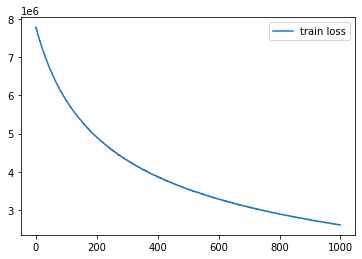

In [61]:

timestamp = time.strftime("march%d_t%H%M_3D_baseline", time.gmtime())
model = model.cuda()
likelihood = likelihood.cuda()

# Find optimal model hyperparameters
model.train()
likelihood.train()

val_loss = []
train_loss = []
train_loss_ = []

n_val = 3
n_test = 7

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 1000
val_on = False
# norm_train = 1000 / clusters.count_stars_train()
for i in range(training_iter):
    # X = clusters.next_train()
    # train_x = torch.from_numpy(X).float().cuda()
    # train_y = torch.from_numpy(estimate_density(X)).float().cuda()
    # model.set_train_data(inputs=train_x, targets=train_y, strict=False)
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    #print(output.sample())
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    #norm_loss = loss.item() * norm_train
    print('Iter %d/%d - Loss: %.3f  -  lengthscale: %.3f - noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    train_loss_.append(loss.item())
    if loss.item() < 0.01:
      break
    optimizer.step()
    if i % n_test == 0 and val_on:
      train_loss.append(np.sum(train_loss_))
      train_loss_ = []
      model.eval()
      likelihood.eval()
      val_loss_ = []
      for j in range(n_val):
        X = clusters.next_val(j)
        norm_val = 1000 / clusters.count_stars_val(j)
        val_x = torch.from_numpy(X).float().cuda()
        val_y = torch.from_numpy(estimate_density(X)).float().cuda()
        output = model(val_x)
        loss = -mll(output, val_y)
        val_loss_.append(loss.item() * norm_val)
        print('*** VALIDATION  %d/%d - Validation Loss %d: %.3f - Normalized: %.3f   ' % (
          i + 1, training_iter, j + 1, loss.item(), loss.item() * norm_val
        ))
      val_loss.append(val_loss_)
      model.train()
      likelihood.train()

# val_loss = np.array(val_loss)
plt.plot(train_loss_, label='train loss')
# plt.plot(val_loss[:, 0], label='val loss 1')
# plt.plot(val_loss[:, 1], label='val loss 2')
# plt.plot(val_loss[:, 2], label='val loss 3')
plt.legend()
plt.savefig(f'./drive/MyDrive/star_clusters_gen/{timestamp}.png')
plt.show()
torch.save(model.state_dict(), f'./drive/MyDrive/star_clusters_gen/{timestamp}.pth')


In [ ]:
!ls ./drive/MyDrive/star_clusters_gen/

data		       march08_t1337_cut.png  march08_t1439.png
march08_t1241.png      march08_t1337.png      march08_t1439.pth
march08_t1241.pth      march08_t1416_150.pth  march09_t1310.cluster.npy
march08_t1337_100.pth  march08_t1416.png


In [ ]:
# Load saved model weights
checkpoint = torch.load('./drive/MyDrive/star_clusters_gen/march17_t1501.pth')

# Load weights into model
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [62]:
model.eval()
likelihood.eval()
#X = clusters.next_train()
#val_x = torch.from_numpy(X).float().cuda()
#val_y = torch.from_numpy(estimate_density(X)).float().cuda()
f_preds = model(train_x)
y_preds = likelihood(f_preds)

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size([1,]))

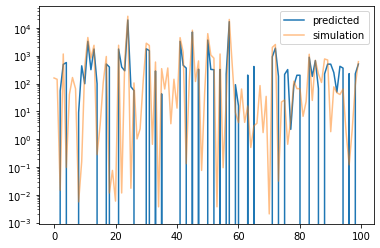

In [63]:
with torch.no_grad():
  #plt.plot(y_preds.variance.cpu().numpy(), label='predicted')
  
  plt.plot(y_preds.mean.cpu().numpy()[:100], label='predicted')
  plt.plot(train_y.cpu()[:100], label='simulation', alpha=0.5)
  
  plt.yscale('log')
  
  plt.legend()

### MCMC sampling results

In [45]:
timestamp = time.strftime("march%d_t%H%M", time.gmtime())
sampler = MCMCSampler(model, likelihood, clusters, 3500, random_seed=40)
step_size=0.5
samples = sampler.sample(step_size=step_size)
np.save(f'./drive/MyDrive/star_clusters_gen/{timestamp}_{step_size}_3D_baseline.cluster', samples)
x = samples


# std t (min)
# 0.5 4.4
# 0.6 3.7
# 0.8 4.3
# 1.0 4.1
# 1.5 3.6



/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100/3500 generated samples [time: 0.076 minutes]
200/3500 generated samples [time: 0.152 minutes]
300/3500 generated samples [time: 0.251 minutes]
400/3500 generated samples [time: 0.324 minutes]
500/3500 generated samples [time: 0.403 minutes]
600/3500 generated samples [time: 0.502 minutes]
700/3500 generated samples [time: 0.579 minutes]
800/3500 generated samples [time: 0.669 minutes]
900/3500 generated samples [time: 0.752 minutes]
1000/3500 generated samples [time: 0.826 minutes]
1100/3500 generated samples [time: 0.927 minutes]
1200/3500 generated samples [time: 1.002 minutes]
1300/3500 generated samples [time: 1.078 minutes]
1400/3500 generated samples [time: 1.191 minutes]
1500/3500 generated samples [time: 1.280 minutes]
1600/3500 generated samples [time: 1.370 minutes]
1700/3500 generated samples [time: 1.455 minutes]
1800/3500 generated samples [time: 1.529 minutes]
1900/3500 generated samples [time: 1.627 minutes]
2000/3500 generated samples [time: 1.704 minutes]
2100/3500

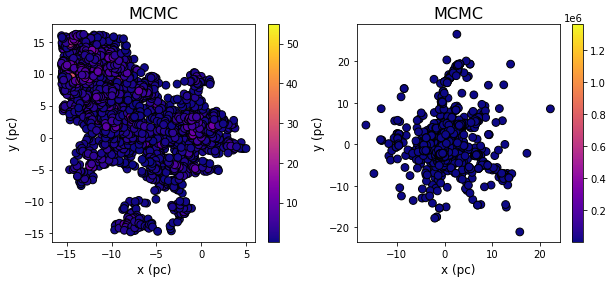

In [49]:
# Create the figure and axes objects
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot the data and the estimate density on the first axis
ax1.scatter(x[:,0], x[:,2], c=estimate_density(x), edgecolor="k", s=60, cmap="plasma")
ax1.set_title('MCMC', fontsize=16)
ax1.set_xlabel('x (pc)', fontsize=12)
ax1.set_ylabel('y (pc)', fontsize=12)
fig.colorbar(ax1.collections[0], ax=ax1)

# Plot the data and the estimate density on the second axis
ax2.scatter(X[:,0], X[:,2], c=estimate_density(X), edgecolor="k", s=60, cmap="plasma")
ax2.set_title('MCMC', fontsize=16)
ax2.set_xlabel('x (pc)', fontsize=12)
ax2.set_ylabel('y (pc)', fontsize=12)
fig.colorbar(ax2.collections[0], ax=ax2)

# Show the plot
plt.show()


## MCMC GoBack

In [50]:
timestamp = time.strftime("march%d_t%H%M", time.gmtime())
N = len(X) - 1 
sampler = MCMCSampler(model, likelihood, clusters, N, random_seed=40)
step_size=1.0
samples = sampler.sample(step_size=step_size, goback=False, random_walk=True, ref=X)
np.save(f'./drive/MyDrive/star_clusters_gen/{timestamp}_{step_size}_3D.cluster_goback', samples)
x = samples
# 0.5  5.4
# 0.7 5.5   1.3
# 1.0 6.4   1.3
# 1.2 6.9

0/2944 generated samples [time: 0.004 minutes]
0/2944 generated samples [time: 0.005 minutes]
0/2944 generated samples [time: 0.007 minutes]
0/2944 generated samples [time: 0.009 minutes]
0/2944 generated samples [time: 0.010 minutes]
0/2944 generated samples [time: 0.012 minutes]
0/2944 generated samples [time: 0.013 minutes]
0/2944 generated samples [time: 0.013 minutes]
0/2944 generated samples [time: 0.014 minutes]
0/2944 generated samples [time: 0.015 minutes]
0/2944 generated samples [time: 0.016 minutes]
0/2944 generated samples [time: 0.017 minutes]
0/2944 generated samples [time: 0.018 minutes]
0/2944 generated samples [time: 0.019 minutes]
100/2944 generated samples [time: 0.231 minutes]
200/2944 generated samples [time: 0.445 minutes]
300/2944 generated samples [time: 0.637 minutes]
400/2944 generated samples [time: 1.172 minutes]
500/2944 generated samples [time: 1.359 minutes]
600/2944 generated samples [time: 1.547 minutes]
700/2944 generated samples [time: 1.736 minutes]

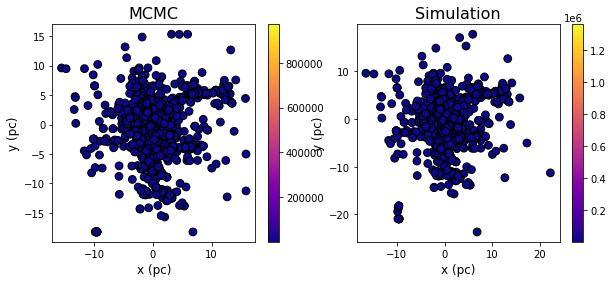

In [53]:
# Create the figure and axes objects
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot the data and the estimate density on the first axis
ax1.scatter(x[:,0], x[:,1], c=estimate_density(x), edgecolor="k", s=60, cmap="plasma")
ax1.set_title('MCMC', fontsize=16)
ax1.set_xlabel('x (pc)', fontsize=12)
ax1.set_ylabel('y (pc)', fontsize=12)
fig.colorbar(ax1.collections[0], ax=ax1)

# Plot the data and the estimate density on the second axis
ax2.scatter(X[:,0], X[:,1], c=estimate_density(X), edgecolor="k", s=60, cmap="plasma")
ax2.set_title('Simulation', fontsize=16)
ax2.set_xlabel('x (pc)', fontsize=12)
ax2.set_ylabel('y (pc)', fontsize=12)
fig.colorbar(ax2.collections[0], ax=ax2)

# Show the plot
plt.show()
